In [1]:
#import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read data
train_data = pd.read_excel('DataSets/THA2train.xlsx')
validate_data = pd.read_excel('DataSets/THA2validate.xlsx')

In [3]:
# data separation features and labels
X_train = train_data.iloc[:, :-1].values
y_train = pd.get_dummies(train_data.iloc[:, -1]).values

In [4]:
# data separation features and labels
X_validate = validate_data.iloc[:, :-1].values
y_validate = pd.get_dummies(validate_data.iloc[:, -1]).values

In [5]:
#this function is for sigmoid by handeling overflow
def sigmoid(z):
    return np.where(z >= 0, 
                    1 / (1 + np.exp(-z)), 
                    np.exp(z) / (1 + np.exp(z)))

In [6]:
#derivative of sigmoid
def sigmoid_derivative(a):
    return a * (1 - a)

In [7]:
#softmax function
def softmax(z):
    e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return e_z / np.sum(e_z, axis=1, keepdims=True)

In [8]:
#the MLP class
class MLP:
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.zeros((input_size, hidden_size))
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.zeros((hidden_size, output_size))
        self.b2 = np.zeros((1, output_size))

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = softmax(self.z2)
        return self.a2

    def backward(self, X, y):
        output_error = self.a2 - y
        dW2 = np.dot(self.a1.T, output_error)
        db2 = np.sum(output_error, axis=0, keepdims=True)
        
        hidden_error = np.dot(output_error, self.W2.T) * sigmoid_derivative(self.a1)
        dW1 = np.dot(X.T, hidden_error)
        db1 = np.sum(hidden_error, axis=0, keepdims=True)
        
        return dW1, db1, dW2, db2

    def update_weights(self, dW1, db1, dW2, db2, learning_rate):
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m  
        return loss



In [9]:
# Normalize the data
X_train_norm = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_validate_norm = (X_validate - np.mean(X_validate, axis=0)) / np.std(X_validate, axis=0)


In [10]:
# Create the MLP model
mlp = MLP(input_size=2, hidden_size=10, output_size=2)


In [11]:
# Training hyperparameters
epochs = 2000
learning_rate = 0.01
batch_size = 32

# Lists to store loss for plotting
training_losses = []
validation_losses = []

In [12]:
# Training loop
for epoch in range(epochs):
    indices = np.arange(X_train_norm.shape[0])
    np.random.shuffle(indices)
    X_train_norm_shuffled = X_train_norm[indices]
    y_train_shuffled = y_train[indices]


    for start_idx in range(0, X_train_norm.shape[0], batch_size):
        end_idx = min(start_idx + batch_size, X_train_norm.shape[0])
        X_batch = X_train_norm_shuffled[start_idx:end_idx]
        y_batch = y_train_shuffled[start_idx:end_idx]

        predictions = mlp.forward(X_batch)
        dW1, db1, dW2, db2 = mlp.backward(X_batch, y_batch)

        mlp.update_weights(dW1, db1, dW2, db2, learning_rate)

    train_loss = mlp.compute_loss(y_train, mlp.forward(X_train_norm))
    validation_loss = mlp.compute_loss(y_validate, mlp.forward(X_validate_norm))
    training_losses.append(train_loss)
    validation_losses.append(validation_loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}")



Epoch 0, Training Loss: 0.7025, Validation Loss: 0.7025
Epoch 100, Training Loss: 0.6945, Validation Loss: 0.6945
Epoch 200, Training Loss: 0.6944, Validation Loss: 0.6944


Epoch 300, Training Loss: 0.6945, Validation Loss: 0.6946
Epoch 400, Training Loss: 0.6940, Validation Loss: 0.6973
Epoch 500, Training Loss: 0.6791, Validation Loss: 0.6868
Epoch 600, Training Loss: 0.6319, Validation Loss: 0.6490
Epoch 700, Training Loss: 0.5947, Validation Loss: 0.6153
Epoch 800, Training Loss: 0.5782, Validation Loss: 0.6003
Epoch 900, Training Loss: 0.5699, Validation Loss: 0.5935
Epoch 1000, Training Loss: 0.5644, Validation Loss: 0.5870
Epoch 1100, Training Loss: 0.5609, Validation Loss: 0.5858
Epoch 1200, Training Loss: 0.5585, Validation Loss: 0.5840
Epoch 1300, Training Loss: 0.5564, Validation Loss: 0.5820
Epoch 1400, Training Loss: 0.5550, Validation Loss: 0.5813
Epoch 1500, Training Loss: 0.5538, Validation Loss: 0.5793
Epoch 1600, Training Loss: 0.5535, Validation Loss: 0.5818
Epoch 1700, Training Loss: 0.5521, Validation Loss: 0.5781
Epoch 1800, Training Loss: 0.5513, Validation Loss: 0.5786
Epoch 1900, Training Loss: 0.5508, Validation Loss: 0.5790


In [13]:
#calculate accuracy
def calculate_accuracy(true_labels, predicted_labels):
    correct_predictions = np.sum(true_labels == predicted_labels)
    accuracy = correct_predictions / true_labels.shape[0]
    return accuracy

In [14]:
#confusion matrix 
def create_confusion_matrix(true_labels, predicted_labels, num_classes):
    # Initialize the confusion matrix to zeros
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    # Populate the confusion matrix by counting the correct predictions
    for true, pred in zip(true_labels, predicted_labels):
        conf_matrix[true][pred] += 1
    return conf_matrix

In [15]:
# Assuming y_validate is one-hot encoded, convert it to class labels
y_validate_class = np.argmax(y_validate, axis=1)

# Generate predictions for the validation set
y_pred_validation = mlp.forward(X_validate_norm)

# Convert predictions to class labels
y_pred_validation_class = np.argmax(y_pred_validation, axis=1)


In [16]:
#accuracy on validation set
validation_accuracy= calculate_accuracy(y_validate_class, y_pred_validation_class)

#confusion matrix for the validation set
conf_matrix= create_confusion_matrix(y_validate_class, y_pred_validation_class, num_classes=2)


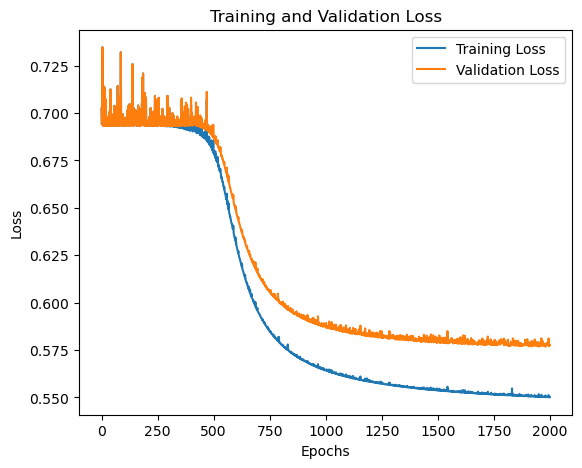

In [17]:
# Plot training and validation loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

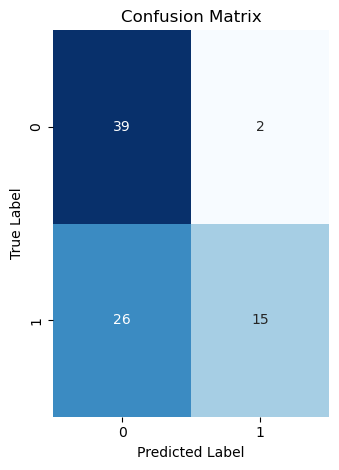

In [18]:
# Plot confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [19]:
print(f'The validation accuracy is : {validation_accuracy*100}%')

The validation accuracy is : 65.85365853658537%


In [20]:
conf_matrix

array([[39,  2],
       [26, 15]])